# Import Libraries

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
from datetime import date, timedelta
import datetime as dt
from dateutil.relativedelta import relativedelta
import time

# Volatility & Stock Paths

In [2]:
def time_splits(T, n):

    def calculate_expiry(T):
        today = date.today()
        days = T * 365.25  # Approximate days for given T years
        months = int(days // 30.4375)  # Approximate number of months (average month length)
        remaining_days = int(days - months * 30.4375)  # Remaining days after converting to months
        expiry = today + relativedelta(months=+months, days=+remaining_days)
        return expiry

    # Calculate expiry date based on T years
    today = date.today()
    expiry = calculate_expiry(T)

    # Generate n evenly spaced time points in years between today and expiry
    times = [i * T / (n - 1) for i in range(n)]  # Time points in years from 0 to T
    dates = [today + timedelta(days=int(time * 365.25)) for time in times]  # Convert to dates

    return {'times': times, 'dates': dates}

The function below returns the volatility and stock paths.

In [102]:
def volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N, T):

  times = time_splits(T,n)['times']

  V = []
  S = []

  for j in range(N):
      rng = np.random.default_rng()
      mean = [0, 0]
      cov = [[1, corr], [corr, 1]]
      samples = rng.multivariate_normal(mean, cov, size=n, method='cholesky')

      v = [v0]  # list to store volatility values
      s = [S0]
      for i in range(1, n):
          delta_t = times[i] - times[i - 1]
          assert delta_t >= 0.00001, print(f'{delta_t} is negative')

          #n components of volatility path for 1 simulation
          vi = v[i - 1] + kappa * (theta - v[i - 1]) * delta_t + eps * np.sqrt(v[i - 1] * delta_t) * samples[i, 1]
          assert v[i - 1] * delta_t >= 0, print(v[i - 1] * delta_t)
          vi_max = max(vi, 0)
          v.append(vi_max)

          #n components of stock path for 1 simulation
          Si = s[i - 1]*np.exp((r - q - v[i - 1]/2)*delta_t + np.sqrt(v[i - 1]*delta_t)*samples[i, 0]) #make sure to add dividend yield here
          Si_max = max(Si,0)
          s.append(Si_max)
      V.append(v)
      S.append(s)

  return {'volatility paths': V, 'stock paths': S, 'Time (years)': times}

# Visualization of Paths

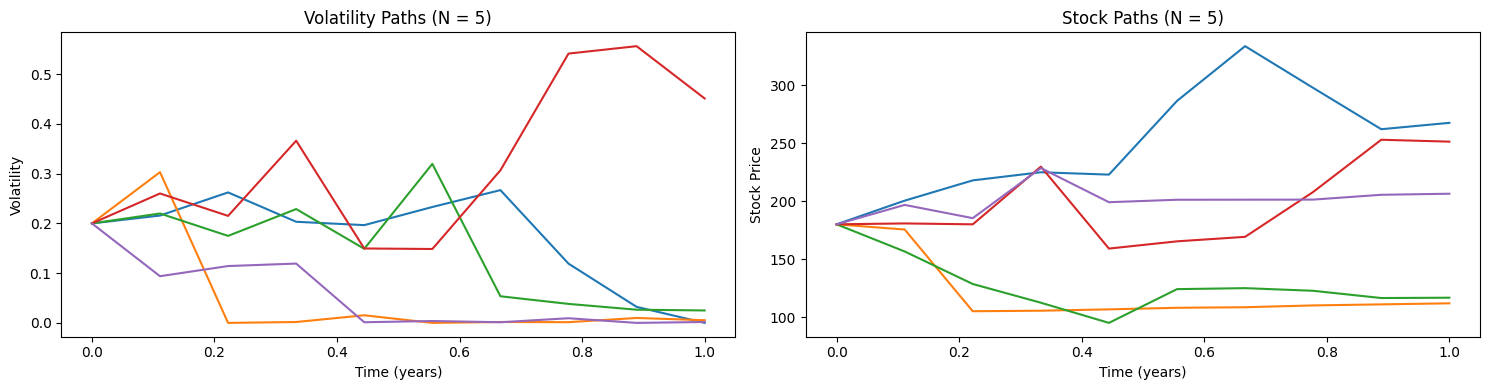

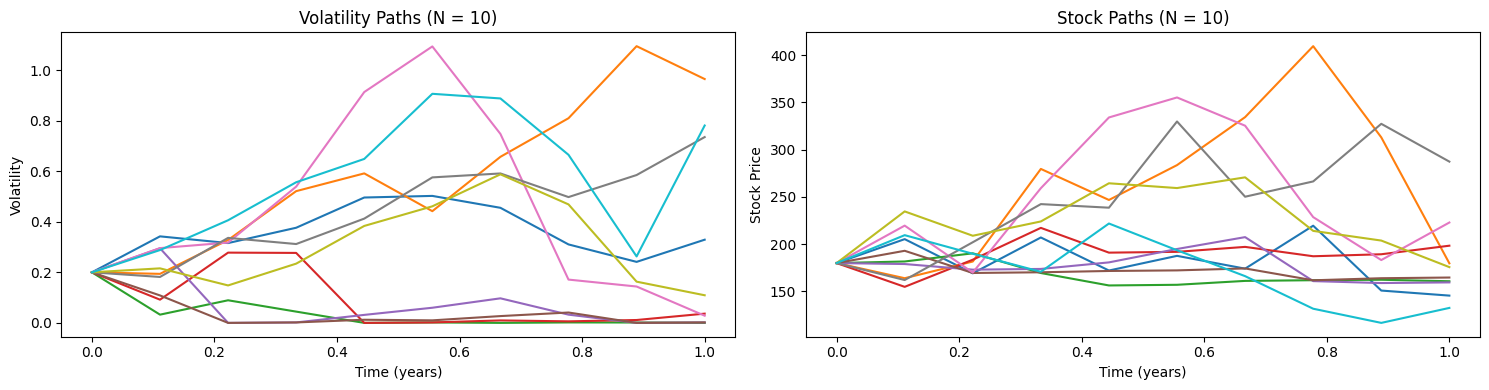

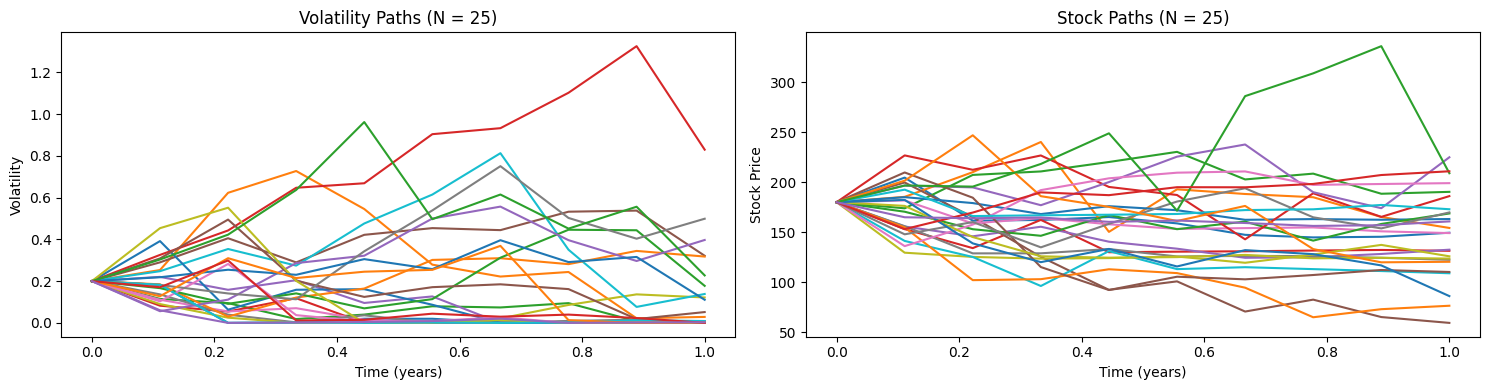

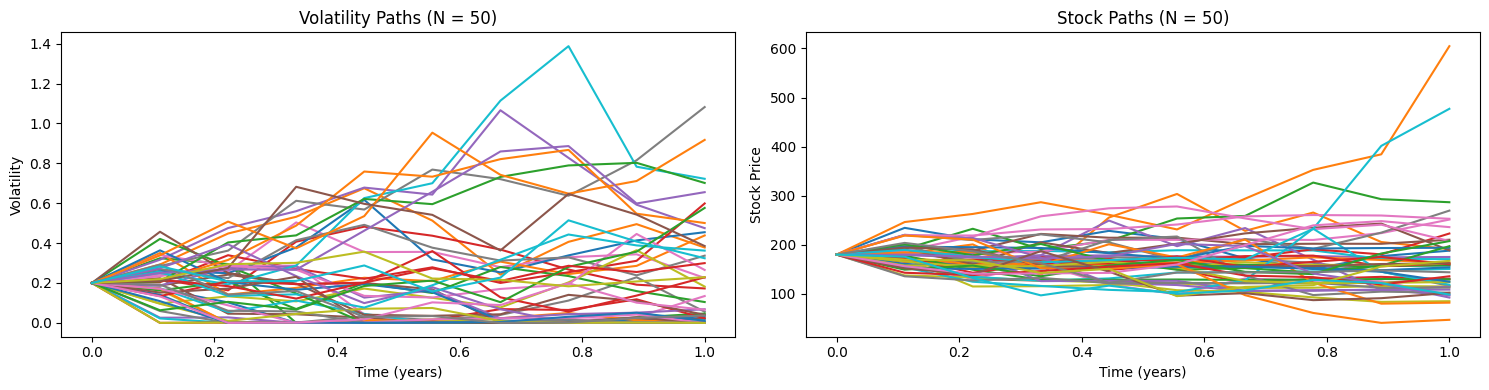

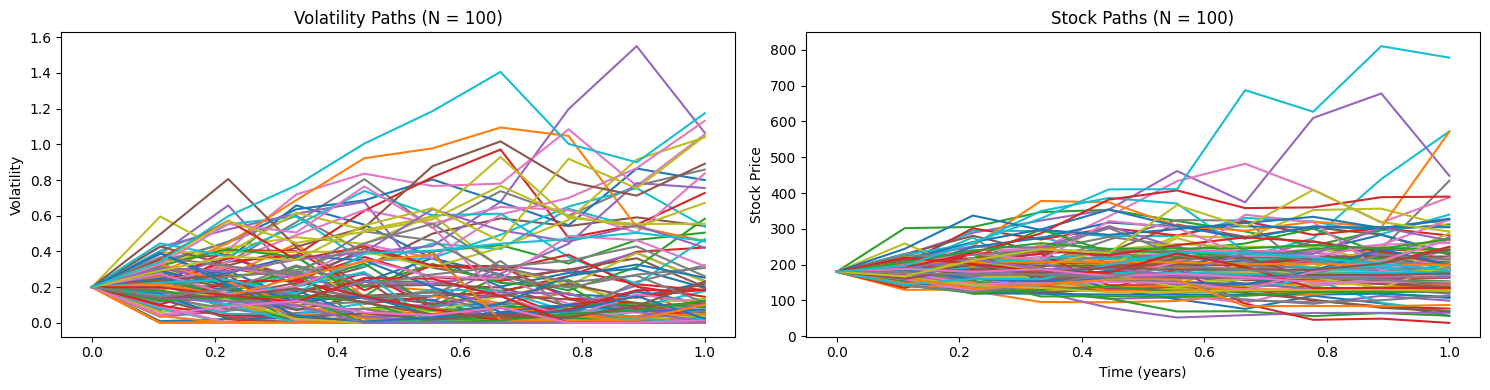

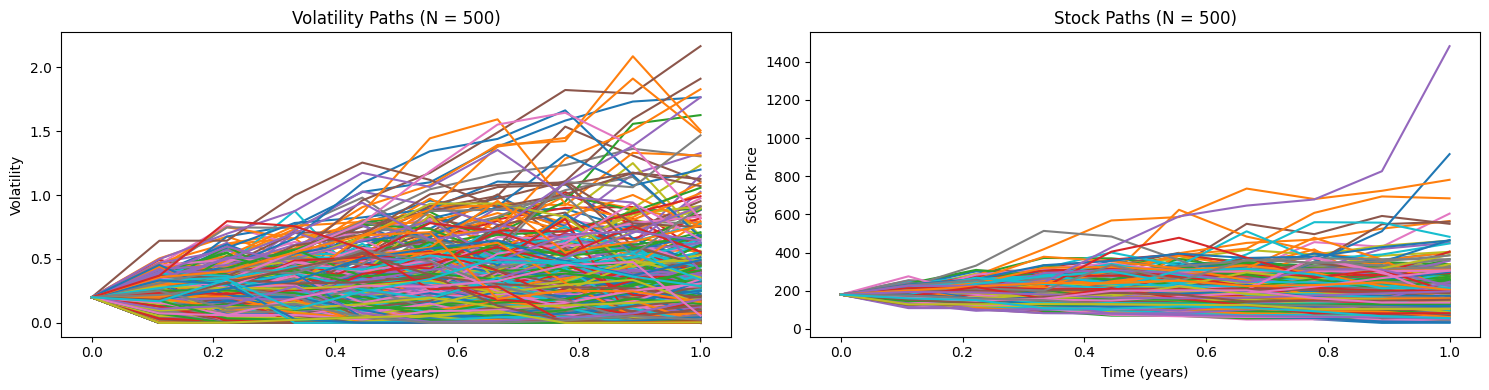

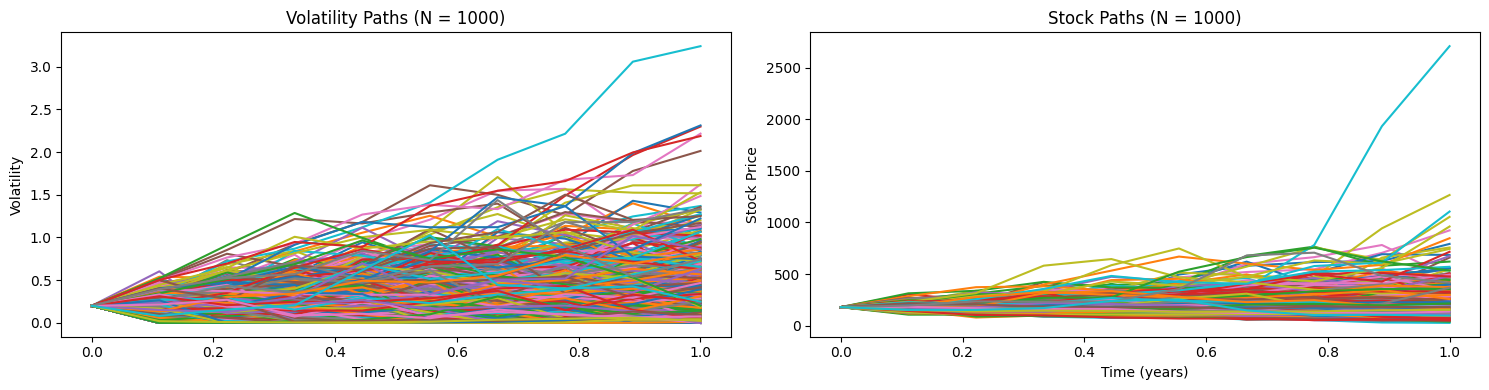

In [7]:
# Parameters
S0 = 180  # Initial stock price
r = 0.04  # Risk-free rate
kappa = 0.08  # Mean reversion speed
theta = 0.20  # Long-term volatility
v0 = 0.20  # Initial volatility
eps = 0.80  # Volatility of volatility
corr = 0.4  # Correlation between stock and volatility
T = 1 #number of years
n = 10  # Number of time steps (within T years)
N_values = [5, 10, 25, 50, 100, 500, 1000] #Number of simulations, will iterate through each.

for N in N_values:

    result = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N, T)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)

    for path in result['volatility paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Volatility Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Volatility')

    plt.subplot(1, 2, 2)
    for path in result['stock paths']:
        plt.plot(result['Time (years)'], path)
    plt.title(f'Stock Paths (N = {N})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')

    plt.tight_layout()
    plt.show()


# European Call Option - Heston Model

## Set Parameters

In [52]:
# Heston model parameters
# kappa: mean reversion rate for v(t)
# theta: long-run average of v(t)
# v0: initial squared volatility
# eps: volatility of volatility
# corr: correlation between the standard GM underlying S(t) and v(t)
kappa, theta, v0, eps, corr = 0.8, 0.20, 0.10, 0.80, -0.1

# Monte Carlo parameters
# n: number of time steps
# N: number of simulation paths
n, N = 10, 100000

# European call option parameters
# Strike ranges from 150, 155, ..., 210
S0, T, r, q = 180, 1/12, 0.04, 0.015
strikes = [i for i in range(150, 215, 5)]

## Monte Carlo Derivative Pricing w/ Heston Model

Pricing a European call option using the Heston model.

In [78]:
data = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N, T)

Warning! Running below takes a long time as it is simulating N = 100 thousand paths for the volatility and stock and is not necessary to visualize in pricing.

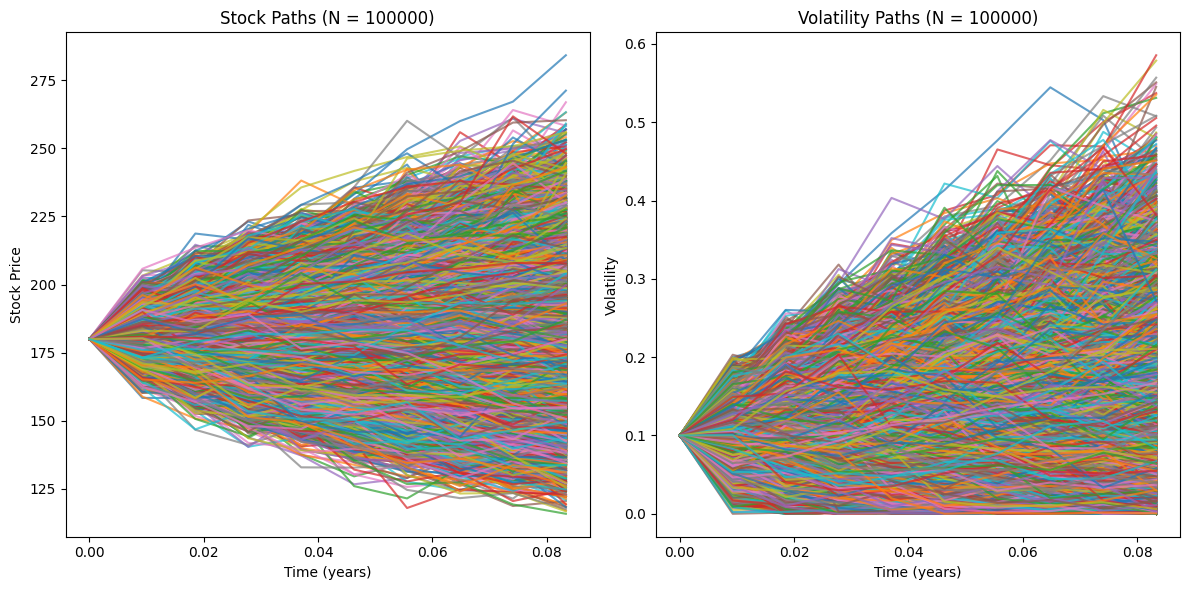

In [6]:
stock_paths = np.array(data['stock paths'])
vol_paths = np.array(data['volatility paths'])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(data['Time (years)'], stock_paths.T, alpha=0.7)  # Transpose to plot each path in a single call
axs[1].plot(data['Time (years)'], vol_paths.T, alpha=0.7)  # Same for volatility

axs[0].set_xlabel('Time (years)')
axs[0].set_ylabel('Stock Price')
axs[0].set_title(f'Stock Paths (N = {N})')

axs[1].set_xlabel('Time (years)')
axs[1].set_ylabel('Volatility')
axs[1].set_title(f'Volatility Paths (N = {N})')

plt.tight_layout()
plt.show()


Now we want to verify the distribution of the stock price at maturity T.  The distribution of the stock price is log normal which appears as normal in this situation due to large mean and low variance.  If we were to adjust the spot closer towards 0 then we would see a more "typical" log normal distribution.

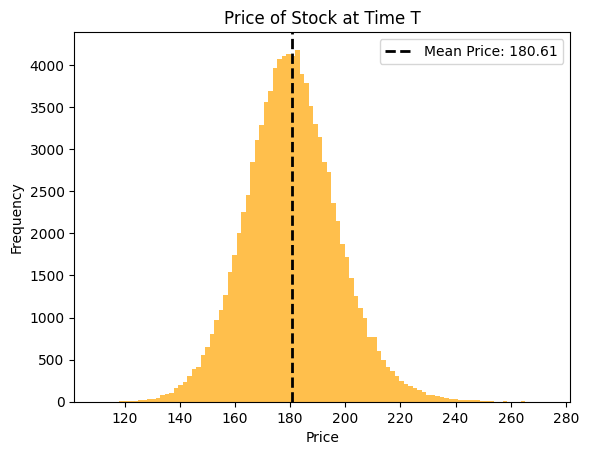

In [90]:
ST = [data['stock paths'][i][-1] for i in range(len(data['stock paths']))]
mean_price = np.mean(ST)
plt.hist(ST, bins=100, color='orange', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price of Stock at Time T')
plt.axvline(x=mean_price, color='black', linestyle='--', linewidth=2, label=f'Mean Price: {mean_price:.2f}')
plt.legend();

Similarly we want to inspect the distribution of the volatility price at maturity T.  There appears to be significant skew which makes sense since the volatility paths are simulated using a standard bivariate normal random variable and they cannot be negative.

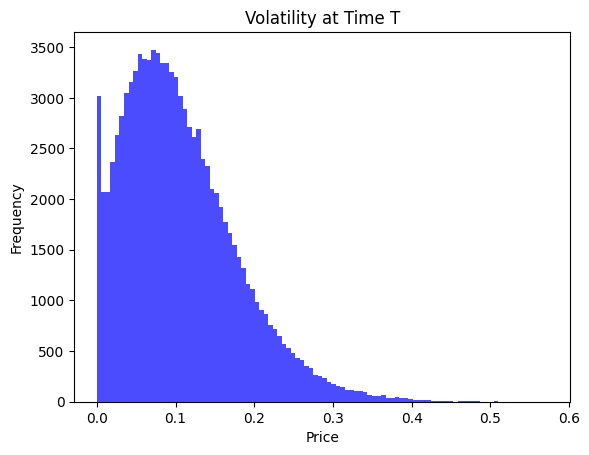

In [98]:
volT = [data['volatility paths'][i][-1] for i in range(len(data['volatility paths']))]
plt.hist(volT, bins=100, color='blue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Volatility at Time T');

Now to calculate the option price by taking the payoff and discounting for each simulation, then taking the mean of all N simulations (to reduce variance).

In [99]:
def call_option_price_heston(S0, T, r, q, K, kappa=None, theta=None, v0=None, eps=None, corr=None, n=None, N=None):

    """Ensure missing parameters have default values"""
    kappa = kappa if kappa is not None else 0.8    # Default kappa
    theta = theta if theta is not None else 0.20   # Default theta
    v0 = v0 if v0 is not None else 0.10            # Default v0
    eps = eps if eps is not None else 0.80         # Default eps
    corr = corr if corr is not None else -0.1      # Default corr
    n = n if n is not None else 10                 # Default n (number of time steps)
    N = N if N is not None else 100000             # Default N (number of simulations)

    data = volatility_and_stock_paths(S0, r, kappa, theta, v0, eps, corr, n, N, T)
    ST = np.array([data['stock paths'][i][-1] for i in range(len(data['stock paths']))])
    disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
    sim_price = np.mean(disc_payoffs)
    return sim_price


In [104]:
start_time = time.time()

strike_price_dict = {'Strike':[], 'Heston Model (Price)':[]}
for k in strikes:
  strike_price_dict['Heston Model (Price)'].append(call_option_price_heston(S0, T, r, q, k))
  strike_price_dict['Strike'].append(k)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds")


Execution time: 165.9675 seconds


In [106]:
df = pd.DataFrame(strike_price_dict)
df

,Strike,Heston Model (Price)
0,150,30.356913
1,155,25.715037
2,160,21.097306
3,165,16.829260
4,170,12.972328
5,175,9.594216
6,180,6.707098
7,185,4.538537
8,190,2.948442
9,195,1.820490


These are the prices of a single simulated option price (for different strikes K = 150, 155, ..., 210.  If we wanted to get a better estimate we would need to run many simulations and then take the expected value of this array of prices.  For example, consider the code chunk below.

In [108]:
start_time = time.time()

estimate = []
sims = 5 #push towards inf depending on compuational power
for i in range(sims):
  estimate.append(call_option_price_heston(S0, T, r, q, 150))

heston_price = np.mean(np.array(estimate))


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.4f} seconds\n")

print(f'The heston model price: ${heston_price}')

Execution time: 70.7656 seconds

The heston model price: $30.454968886380545


In [114]:
print(f'A better estimate for the C150 is ${np.mean(estimate):.4f} (using number of option price simulations = {sims})\n\n clearly as the number of option price simulations increase the variance in our estimate will decrease')

A better estimate for the C150 is $30.4550 (using number of option price simulations = 5)

 clearly as the number of option price simulations increase the variance in our estimate will decrease


Therefore, let us run each option price for each strike 5 times.  This should be computationally expensive but will yield better results in the proceeding calculations.

!!! Warning runtime is very long !!!

In [117]:
start_time = time.time()

heston_prices_ladder = {k:[] for k in strikes}
for i in range(5):
  for k in strikes:
    heston_prices_ladder[k].append(call_option_price_heston(S0, T, r, q, k))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

Execution time: 851.5625 seconds


In [140]:
df_multiple_sims = pd.DataFrame(heston_prices_ladder).T.reset_index()
df_multiple_sims = df_multiple_sims.rename(columns = {'index':'Strikes', 0:'Price 1', 1:'Price 2', 2:'Price 3', 3:'Price 4', 4:'Price 5'})
df_multiple_sims['Average Price'] = df_multiple_sims.loc[:,'Price 1':].mean(axis = 1)
df_multiple_sims

,Strikes,Price 1,Price 2,Price 3,Price 4,Price 5,Average Price
0,150,30.383891,30.448343,30.413745,30.437313,30.516529,30.439964
1,155,25.675770,25.710647,25.697339,25.763642,25.772401,25.723960
2,160,21.153257,21.149269,21.100125,21.039263,21.053488,21.099081
3,165,16.810343,16.767490,16.766872,16.835573,16.716050,16.779266
4,170,12.900492,12.849588,12.851248,12.902107,12.926596,12.886006
5,175,9.535884,9.466287,9.535464,9.556464,9.513030,9.521426
6,180,6.740010,6.716830,6.706837,6.669299,6.691612,6.704918
7,185,4.516720,4.540023,4.500195,4.551611,4.515068,4.524723
8,190,2.968362,2.942567,2.929512,2.954465,2.942627,2.947506
9,195,1.809251,1.842161,1.828137,1.843991,1.841269,1.832962


# Implied Volatility & Volatility Smile

Now, clearly the computational costs pose an issue.  Therefore, assume that 1 simulation is enough, and we get a 'good' estimate for the European call option.  Let us calculate the implied volatility assuming this price is the BSM price on the market.

In [130]:
def BSM_call_price(S0, T, r, q, K, v):
  d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
  d2 = d1 - v*np.sqrt(T)
  price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
  return price

In [151]:
df_optimization = df_multiple_sims[['Strikes', 'Average Price']].rename(columns = {'Average Price': 'Heston Model (Price)'})
df_optimization['Lower Bound'] = [BSM_call_price(180, 1/12, 0.04, 0.015, k, 10**-5) for k in strikes]
df_optimization['Heston - BSM lb'] = df_multiple_sims['Average Price'] - df['BSM (Price) & v0 = 10**-5']
df_optimization['Convergence'] = df['Heston - BSM'].apply(lambda x: True if x>=0 else False)
assert df_optimization['Convergence'].all() == True, 'cannot optimize'
df_optimization

,Strikes,Heston Model (Price),Lower Bound,Heston - BSM lb,Convergence
0,150,30.439964,30.274308,0.165656,True
1,155,25.723960,25.290947,0.433013,True
2,160,21.099081,20.307586,0.791495,True
3,165,16.779266,15.324225,1.455041,True
4,170,12.886006,10.340864,2.545142,True
5,175,9.521426,5.357503,4.163923,True
6,180,6.704918,0.374142,6.330776,True
7,185,4.524723,0.000000,4.524723,True
8,190,2.947506,0.000000,2.947506,True
9,195,1.832962,0.000000,1.832962,True


In [162]:
def implied_volatility(S0, T, r, q, K, market_price):

    def objective(v):
        bsm_price = BSM_call_price(S0, T, r, q, K, v)
        return bsm_price - market_price

    return optimize.newton(objective, x0=0.3)

In [163]:
S0, T, r, q = 180, 1/12, 0.04, 0.015

market_prices = list(df_optimization['Heston Model (Price)'].values)
implied_vols = {'Strike':[], 'Implied Volatility':[]}
for k, market_price_k in zip(strikes,market_prices):
  imp_vol = implied_volatility(S0, T, r, q, k, market_price_k)
  implied_vols['Strike'].append(k)
  implied_vols['Implied Volatility'].append(imp_vol)

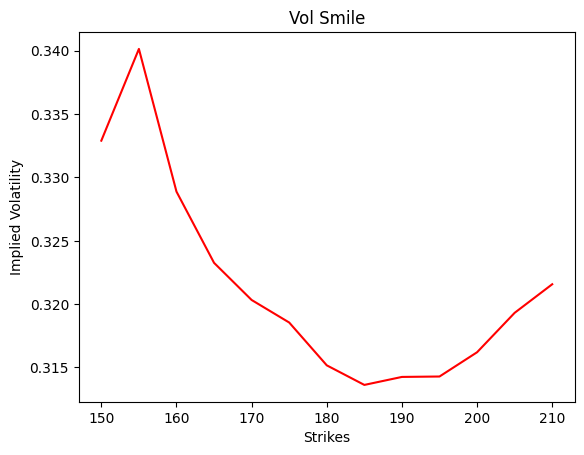

In [164]:
plt.plot(implied_vols['Strike'], implied_vols['Implied Volatility'], color = 'red')
plt.xlabel('Strikes');
plt.ylabel('Implied Volatility');
plt.title('Vol Smile');